[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eirasf/GCED-AA2/blob/main/lab8/lab8.ipynb)
# Práctica 7: Residual neural networks


### Pre-requisitos. Instalar paquetes

Para la primera parte de este Laboratorio 8 necesitaremos torch. Además, como habitualmente, fijaremos la semilla aleatoria para asegurar la reproducibilidad de los experimentos.

In [1]:
import torch

#Fijamos la semilla para poder reproducir los resultados
import os
import numpy as np
import random
seed=1234
os.environ['PYTHONHASHSEED']=str(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Carga del conjunto de datos

De nuevo, seguimos empleando el conjunto *Titanic* ya empleado en los laboratorios anteriores.


In [ ]:
# TODO - Carga el conjunto Titanic. No es necesario hacer particiones, pero asegúrate de que las
# variables estén en la escala apropiada


## Visualización del desvanecimiento del gradiente
Las Residual neural networks se ocupan de que los gradientes no se desvanezcan cuando la red es muy profunda. Vamos a visualizar este problema creando una red profunda y mostrando las dimensiones de los gradientes que llegan a cada capa.

### Creamos un modelo *Sequential*
Creamos un modelo *Sequential* para ajustar a los datos de entrada siguiendo las especificaciones dadas.

In [ ]:
# TODO - Define en model una red MLP con 20 capas ocultas, con activación sigmoide, con 10 unidades por capa.
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, num_hidden_layers = 20, hidden_units = 10, activation=nn.Sigmoid()):
        super(MLP, self).__init__()
        
        # TODO - Completa la clase

### Entrenamiento del modelo
Entrena el modelo durante 10 epochs. En el bucle de entrenamiento, guarda en un diccionario con el formato mostrado el histórico de gradientes de cada capa.

In [ ]:
# TODO - Entrena el modelo durante 10 epochs
# Cambia tu train step guardar los gradientes en un diccionario con este formato:
# g_hist = {name: [] for name, param in model.named_parameters() if 'weight' in name}
# Por cada parámetro que se llame weight (ignoraremos los bias en este ejercicio),
# guardaremos una lista con un valor por cada epoch. En la lista de cada parámetro,
# debes guardar la media de las normas de los gradientes de ese parámetro durante
# los pasos de cada epoch.
# Para calcular la norma del gradiente de un parámetro puedes usar:
# torch.norm(param.grad.detach()))


Ahora que hemos hecho algunos pasos de entrenamiento, representamos el tamaño medio de los pesos de cada capa.

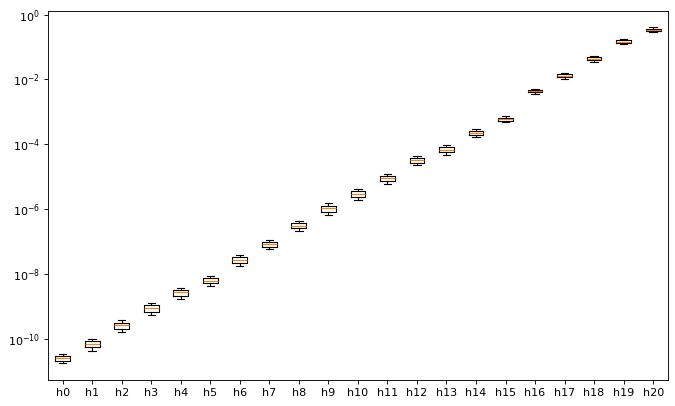

In [5]:
from matplotlib import pyplot as plt
# Ahora accedemos al historial de gradientes y representamos el tamaño medio de los gradientes de cada capa.
plt.figure(figsize=(10, 6), dpi=80)
plt.boxplot(g_hist.values())
plt.yscale('log')
plt.xticks(ticks=range(1,len(g_hist)+1), labels=[f'h{int(k.split('.')[1])//2}' for k in g_hist.keys()])
plt.show()

## Comparativa
 - ¿Qué observas en los pesos?
 - ¿Ocurre lo mismo utilizando ReLU como función de activación de las capas ocultas?
 - Repite la prueba con las distintas [funciones de activación](https://docs.pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) que tengan sentido.
 - Prueba a utilizar He initialization para tus capas Dense (ver código en la celda siguiente)
 - (OPCIONAL) Alarga el entrenamiento y prueba distintos optimizadores para intentar que el modelo entrene correctamente.

In [ ]:
# Ejemplo de He initialization
# for layer in self.model:
#     if isinstance(layer, nn.Linear):
#         nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
#         nn.init.zeros_(layer.bias)

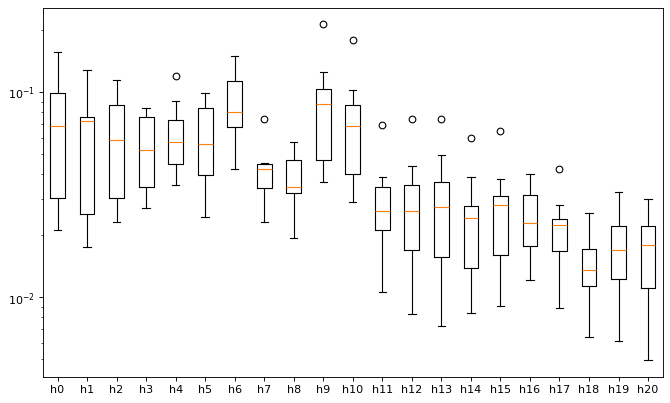

In [ ]:
# Abajo se muestra el resultado con ReLU y He initialization

---
# Parte 2

### Creación del bloque con conexión residual

En una red neuronal *feed-forward* convencional, la salida de cada capa se utiliza como entrada de las capa siguiente.

<img src="./img/resnet.png" alt="Dos capas en una red FF" width="400"/>

En contraste, en una ResNet se introducen bloques que incluyen conexiones residuales con el objetivo de favorecer la propagación de los gradientes.

<img src="./img/resnet-2.png" alt="Dos capas en una red FF con conexión residual" width="400"/>

A pesar de que las ResNet se suelen utilizar con redes convolucionales, en este Laboratorio utilizaremos una red *feed-forward*.

Para poder utilizar este tipo de bloques en nuestra arquitectura definiremos un nuevo tipo de modelo denominado `BlockWithSkipConnection` que consistirá en lo representado en la imagen:
 - Una primera capa con activación, cuya salida sirve de entrada a...
 - Una segunda capa lineal (sin activación), cuya salida sirve de entrada a...
 - A una operación suma que la añade a la entrada original a la primera capa. La salida de esta suma servirá de entrada a...
 - Una función de activación, cuya salida será la salida del bloque.

Utilizaremos la función sigmoide como función de activación en ambos casos. La entrada y la salida del bloque deberán tener la misma dimensión para que se pueda realizar la suma. Por simplicidad, mantendremos la salida de la primera capa con la misma dimensión.

In [ ]:
class BlockWithSkipConnection(nn.Module):
    def __init__(self, dim, outer_activation = nn.Sigmoid(), inner_activation = nn.Sigmoid()):
        super(BlockWithSkipConnection, self).__init__()
        # TODO - Completa la clase

## Creamos un modelo utilizando los nuevos bloques
Creamos un modelo *MLPWithSkipConnections* para ajustar a los datos de entrada siguiendo las especificaciones dadas. Deberá incluir una capa de entrada de 10 unidades con activación sigmoide, 10 de los nuevos bloques y la capa de salida apropiada.

In [ ]:
class MLPWithSkipConnections(nn.Module):
    def __init__(self, input_dim, output_dim, num_blocks = 10, hidden_units = 10, activation = nn.Sigmoid()):
        super(MLPWithSkipConnections, self).__init__()
        # TODO - Completa la clase

0/10:	Loss:0.6992
1/10:	Loss:0.6962
2/10:	Loss:0.6931
3/10:	Loss:0.69
4/10:	Loss:0.6882
5/10:	Loss:0.6852
6/10:	Loss:0.6846
7/10:	Loss:0.6812
8/10:	Loss:0.6805
9/10:	Loss:0.6793


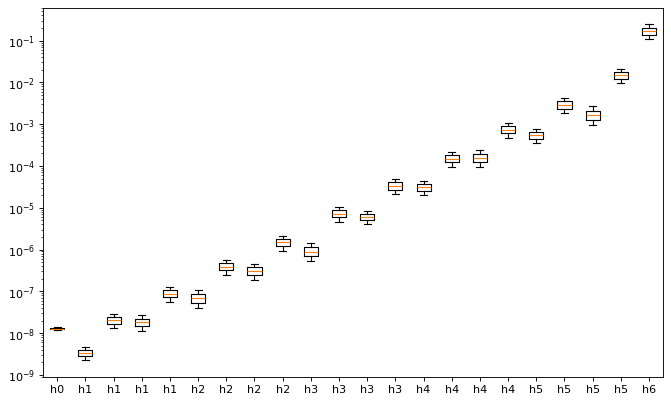

In [ ]:
# TODO - Entrena el modelo guardando en g_hist el histórico de gradientes

# Ahora accedemos al historial de gradientes y representamos el tamaño medio de los gradientes de cada capa.
plt.figure(figsize=(10, 6), dpi=80)
plt.boxplot(g_hist.values())
plt.yscale('log')
plt.xticks(ticks=range(1,len(g_hist)+1), labels=[f'h{int(k.split('.')[1])//2}' for k in g_hist.keys()])
plt.show()

## Comparativa
 - Contrasta los resultados con los obtenidos en la primera parte
 - Cambia las activaciones del exteriores del bloque y de la primera capa oculta de la red a ReLU y observa la diferencia.
 - Alarga el entrenamiento y prueba distintos optimizadores para intentar que el modelo entrene correctamente.